In [1]:
import os
import pandas as pd
import scanpy as sc
features = pd.read_csv("GSE236581_features.tsv.gz", compression='gzip', sep='\t', header=None)

barcodes = pd.read_csv("GSE236581_barcodes.tsv.gz", compression='gzip', header=None)

from scipy.io import mmread

import gzip
with gzip.open("GSE236581_counts.mtx.gz", 'rb') as f:
    counts = mmread(f).tocsc()  # or .tocsr()
print(counts.shape)

(36027, 975275)


In [2]:
import anndata
features.columns = ["gene_id", "gene_name", "feature_type"]
barcodes.columns = ["barcode"]

counts = counts.transpose()  

# Create the AnnData object
adata = anndata.AnnData(X=counts)

# AnnData “obs” (rows) will correspond to cells
adata.obs_names = barcodes["barcode"].values

# AnnData “var” (columns) will correspond to genes
adata.var_names = features["gene_id"].values

# Store additional gene annotations
adata.var["gene_name"] = features["gene_name"].values
adata.var["feature_type"] = features["feature_type"].values

In [3]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
print(adata)

print(adata.X[20:25, 20:25].todense())
print(adata.obs.head())
print(adata.var.head())

AnnData object with n_obs × n_vars = 975275 × 36027
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_name', 'feature_type', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
[[0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 2]
 [0 0 0 0 0]
 [0 0 0 0 1]]
                            n_genes_by_counts  log1p_n_genes_by_counts  \
CRC01-N-I_AAACGGGTCGTTACGA                777                 6.656727   
CRC01-N-I_AACACGTTCCTTCAAT               1303                 7.173192   
CRC01-N-I_AACCATGCAGCTCGAC                605                 6.406880   
CRC01-N-I_AACCGCGTCATGTGGT                801                 6.687109   
CRC01-N-I_AACTGGTGTACAGCAG               3854                 8.257126   

                            total_counts  log1p_total_counts  \

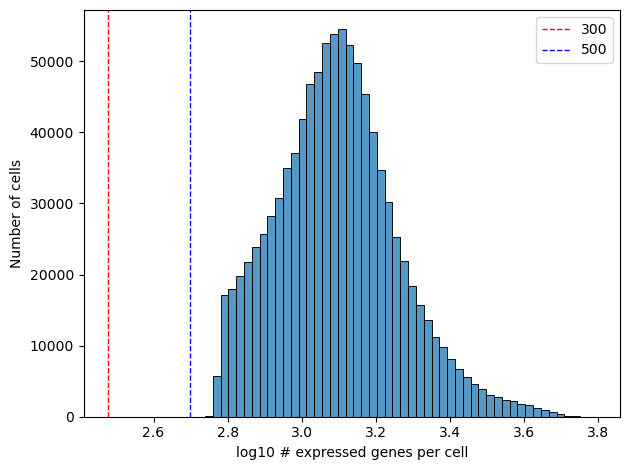

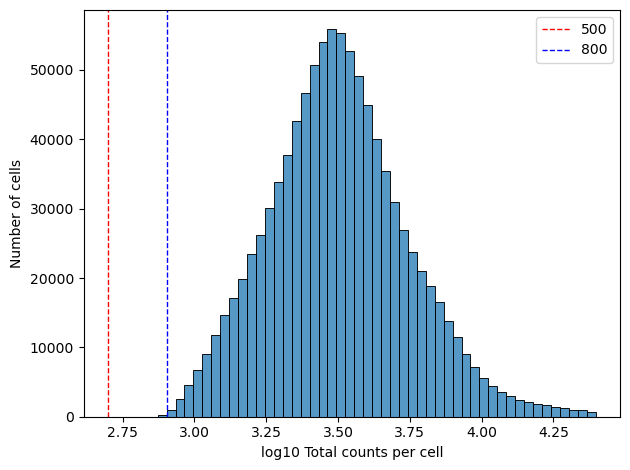

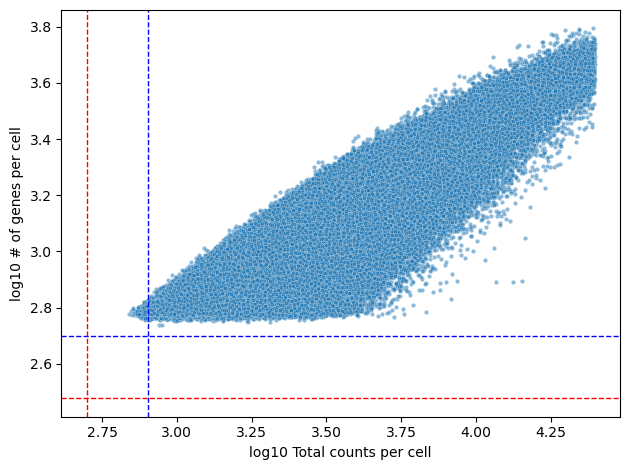

In [4]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
sns.histplot(np.log10(adata.obs['n_genes_by_counts']), bins=50, kde=False)
plt.xlabel('log10 # expressed genes per cell')
plt.ylabel('Number of cells')
plt.axvline(np.log10(300), color='red', linestyle='--', linewidth=1, label='300')
plt.axvline(np.log10(500), color='blue', linestyle='--', linewidth=1, label='500')
plt.legend()
# plt.legend(handles=[line1, line2], loc='upper left')
plt.tight_layout()
plt.show()

sns.histplot(np.log10(adata.obs['total_counts']), bins=50, kde=False)
plt.xlabel('log10 Total counts per cell')
plt.ylabel('Number of cells')
plt.axvline(np.log10(500), color='red', linestyle='--', linewidth=1, label='500')
plt.axvline(np.log10(800), color='blue', linestyle='--', linewidth=1, label='800')
plt.legend()
plt.tight_layout()
plt.show()

# Scatterplot of log10(total_counts) vs log10(n_genes_expressed)
sns.scatterplot(
    x=np.log10(adata.obs['total_counts']),
    y=np.log10(adata.obs['n_genes_by_counts']),
    alpha=0.5, s=10
)
plt.xlabel('log10 Total counts per cell')
plt.ylabel('log10 # of genes per cell')
plt.axhline(np.log10(300), color='red', linestyle='--', linewidth=1)
plt.axhline(np.log10(500), color='blue', linestyle='--', linewidth=1)
plt.axvline(np.log10(500), color='red', linestyle='--', linewidth=1)
plt.axvline(np.log10(800), color='blue', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

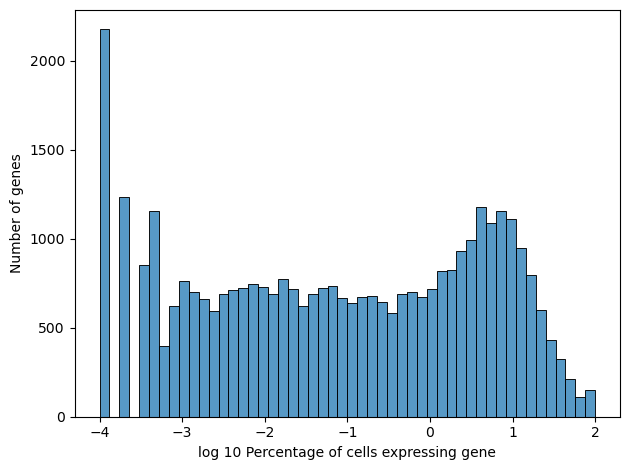

Summary of genes/counts per cell
count    975275.000000
mean       1344.048494
std         579.071398
min         548.000000
25%         958.000000
50%        1231.000000
75%        1563.000000
max        6224.000000
Name: n_genes_by_counts, dtype: float64
count    975275.000000
mean       3777.420859
std        2585.251974
min         693.000000
25%        2202.000000
50%        3120.000000
75%        4476.000000
max       24965.000000
Name: total_counts, dtype: float64
Summary of percent of cells expressing each gene
count    36027.000000
mean         3.730670
std          9.729275
min          0.000000
25%          0.002461
50%          0.086027
75%          2.814386
max         99.779037
Name: pct_cells_expressed, dtype: float64


In [5]:
n_cells = adata.n_obs
adata.var['pct_cells_expressed'] = np.asarray((adata.X > 0).sum(axis=0)).ravel() / n_cells * 100
sns.histplot(np.log10(adata.var['pct_cells_expressed']+1e-4), bins=50, kde=False)
plt.xlabel('log 10 Percentage of cells expressing gene')
plt.ylabel('Number of genes')
plt.tight_layout()
plt.show()

print("Summary of genes/counts per cell")
print(adata.obs['n_genes_by_counts'].describe())
print(adata.obs['total_counts'].describe())

print("Summary of percent of cells expressing each gene")
print(adata.var['pct_cells_expressed'].describe())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


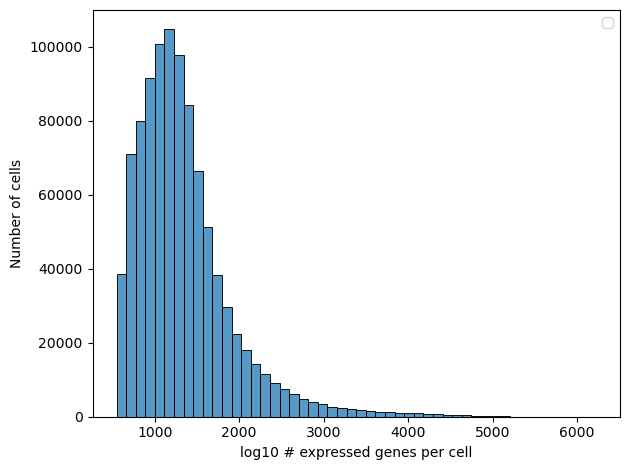

In [6]:
sns.histplot(adata.obs['n_genes_by_counts'], bins=50, kde=False)
plt.xlabel('log10 # expressed genes per cell')
plt.ylabel('Number of cells')
plt.legend()
# plt.legend(handles=[line1, line2], loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
metadata = pd.read_csv("GSE236581_CRC-ICB_metadata.txt.gz", compression='gzip', sep=' ')
adata.obs = adata.obs.join(metadata)

In [8]:
t_cell_types = [
 'c01_CD4_Tn_CCR7',
 'c02_CD4_Tn_SELL',
 'c03_CD4_Tn_NR4A2',
 'c04_CD4_Tcm_ANXA1',
 'c05_CD4_Tcm_GPR183',
 'c06_CD4_Trm_HSPA1A',
 'c07_CD4_Th17_CTSH',
 'c08_CD4_Tfh_CXCL13_IL6ST',
 'c09_CD4_Th1_CXCL13_HAVCR2',
 'c10_CD4_Temra_GZMB',
 'c11_CD4_Treg_FOXP3',
 'c12_CD4_Treg_KLRB1',
 'c13_CD4_Treg_TNFRSF9',
 'c14_CD4_MT',
 'c15_CD8_Tn_CCR7',
 'c16_CD8_Tn_SELL',
 'c17_CD8_Tcm_GPR183',
 'c18_CD8_Tcm_ANXA1',
 'c19_CD8_Tem_CMC1',
 'c20_CD8_Tem_GZMK',
 'c21_CD8_Trm_XCL1',
 'c22_CD8_Trm_HSPA1B',
 'c23_CD8_Tex_LAYN',
 'c24_CD8_Temra_CX3CR1',
 'c25_CD8_Temra_TYROBP',
 'c26_CD8_MAIT_KLRB1',
 'c27_CD8_MAIT_SLC4A10',
 'c28_CD8_IEL_CD160',
]

adata = adata[adata.obs["SubCellType"].isin(t_cell_types)]
print(adata)

View of AnnData object with n_obs × n_vars = 417257 × 36027
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Ident', 'Patient', 'Treatment', 'Tissue', 'MajorCellType', 'SubCellType'
    var: 'gene_name', 'feature_type', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'pct_cells_expressed'


In [9]:
# 1) split
adatas = []
for lib in adata.obs['Ident'].unique():
    ad = adata[adata.obs['Ident'] == lib].copy()
    ad.obs['Ident'] = lib  # ensure the obs column survives
    adatas.append(ad)

# 2) per‐sample normalize & log
for ad in adatas:
    median_depth = np.median(ad.obs['total_counts'].values)
    sc.pp.normalize_total(ad, target_sum=median_depth)
    sc.pp.log1p(ad)  # log transform
# 3) put ’em back together
adata_norm = adatas[0].concatenate(
    adatas[1:],
    batch_key='Ident',
    index_unique=None       # keep original cell barcodes
)

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [10]:
all_genes = set(adata_norm.var['gene_name'].values)
markers = {
    "CD4": ["CD4", "FOXP3", "IL2RA"], #"TRBC2" [CD3D, CD3E, CXCR4, IL7R, LTB, TRBC2] ["IL7R", "CCR7","FOXP3"]  ["CD4", "IL7R", "TRBC2"] https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2023.1151109/full
    "CD8": ["CD8A", "CD8B"]
}
for cell_type, gene_list in markers.items():
    present = [g for g in gene_list if g in all_genes]
    missing = [g for g in gene_list if g not in all_genes]
    print(f"{cell_type} markers:")
    print(" • present:", present)
    print(" • missing:", missing, "\n")

CD4 markers:
 • present: ['CD4', 'FOXP3', 'IL2RA']
 • missing: [] 

CD8 markers:
 • present: ['CD8A', 'CD8B']
 • missing: [] 



In [11]:
%matplotlib inline

hvg_n         = 3000                           # #HVGs to keep
leiden_res    = 1.2                           # tweak for cluster granularity

# -------------------- feature selection & scaling -------------------------
sc.pp.highly_variable_genes(adata_norm, n_top_genes=hvg_n,  flavor="cell_ranger", batch_key="Ident")
# adata_norm.var.set_index("gene_name", inplace=True)
# adata_norm.var.loc["CD4", "highly_variable"] = True

adata_all = adata_norm[:, adata_norm.var["highly_variable"]]  # subset to HVGs                     

In [12]:
all_genes = set(adata_all.var['gene_name'].values)

for cell_type, gene_list in markers.items():
    present = [g for g in gene_list if g in all_genes]
    missing = [g for g in gene_list if g not in all_genes]
    print(f"{cell_type} markers:")
    print(" • present:", present)
    print(" • missing:", missing, "\n")

CD4 markers:
 • present: ['CD4', 'FOXP3', 'IL2RA']
 • missing: [] 

CD8 markers:
 • present: ['CD8A', 'CD8B']
 • missing: [] 



/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


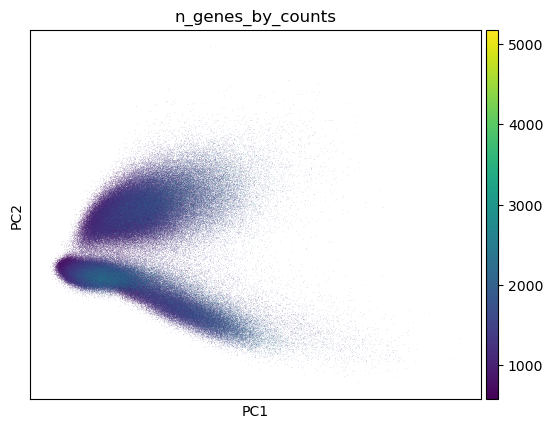

In [13]:
sc.pp.scale(adata_all, max_value=10)

# ----------------------- dimensionality + clustering ----------------------
sc.tl.pca(adata_all, svd_solver="arpack")

sc.pl.pca(adata_all, color="n_genes_by_counts", use_raw=False)
     

In [14]:
sc.pp.neighbors(adata_all,n_neighbors=15, n_pcs=40)
sc.tl.leiden(adata_all, resolution=leiden_res, key_added="cluster")
sc.tl.umap(adata_all)  

/app/software/umap-learn/0.5.3-foss-2022b/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/app/software/umap-learn/0.5.3-foss-2022b/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/app/software/umap-learn/0.5.3-foss-2022b/lib/python3.10

In [15]:
adata_all.var_names = adata_all.var['gene_name']

sc.tl.score_genes(adata_all, gene_list=markers["CD4"], score_name="CD4_score")
sc.tl.score_genes(adata_all, gene_list=markers["CD8"], score_name="CD8_score")

# coarse per‑cluster means
clust_means = (
    adata_all.obs[["cluster", "CD4_score", "CD8_score"]]
    .groupby("cluster")
    .mean()
)
clust_means

CD4_score  CD8_score
cluster                      
0         0.111120  -0.495308
1         0.077764  -0.546369
2        -0.244854   0.490322
3        -0.232182   0.697164
4         0.042153  -0.496782
5         0.068241  -0.485537
6         1.537593  -0.648231
7        -0.195061   1.161350
8        -0.217515   0.812992
9        -0.128288   0.170317
10       -0.244334   0.802394
11        0.054405  -0.418015
12       -0.351703   0.375343
13       -0.303392  -0.063304
14       -0.203947   0.340691
15       -0.054832  -0.546032
16       -0.110521   0.216425
17       -0.070708   0.149715
18       -0.362150  -0.332651
19       -0.200366   0.166418
20        0.993357  -0.604877
21       -0.226069  -0.114256
22       -0.159764  -0.124124
23       -0.360159   0.591379
24       -0.260275   0.502212
25       -0.013555  -0.158212
26        0.066665  -0.379212

In [16]:
import numpy as np
# label clusters: whichever marker score is higher
clust_means["predicted_type"] = np.where(
    clust_means["CD4_score"] > clust_means["CD8_score"], "CD4", "CD8"
)


# map back to every cell
adata_all.obs["CD_type_by_cluster"] = (
    adata_all.obs["cluster"].map(clust_means["predicted_type"])
)

In [17]:
proportion_cd4_gt_cd8 = (
    (adata_all.obs["CD4_score"] > adata_all.obs["CD8_score"])
    .groupby(adata_all.obs["cluster"])
    .mean()
)

clust_means["CD4_gt_CD8_fraction"] = proportion_cd4_gt_cd8

clust_means["predicted_type"] = np.where(
    (clust_means["CD4_score"] > 0) & 
    (clust_means["CD8_score"] < 0) & 
    (clust_means["CD4_gt_CD8_fraction"] > 0.6), 
    "CD4", 
    np.where(
        (clust_means["CD4_score"] < 0) & 
        (clust_means["CD8_score"] > 0) & 
        (clust_means["CD4_gt_CD8_fraction"] < 0.4), 
        "CD8", 
        "unknown"
    )
)


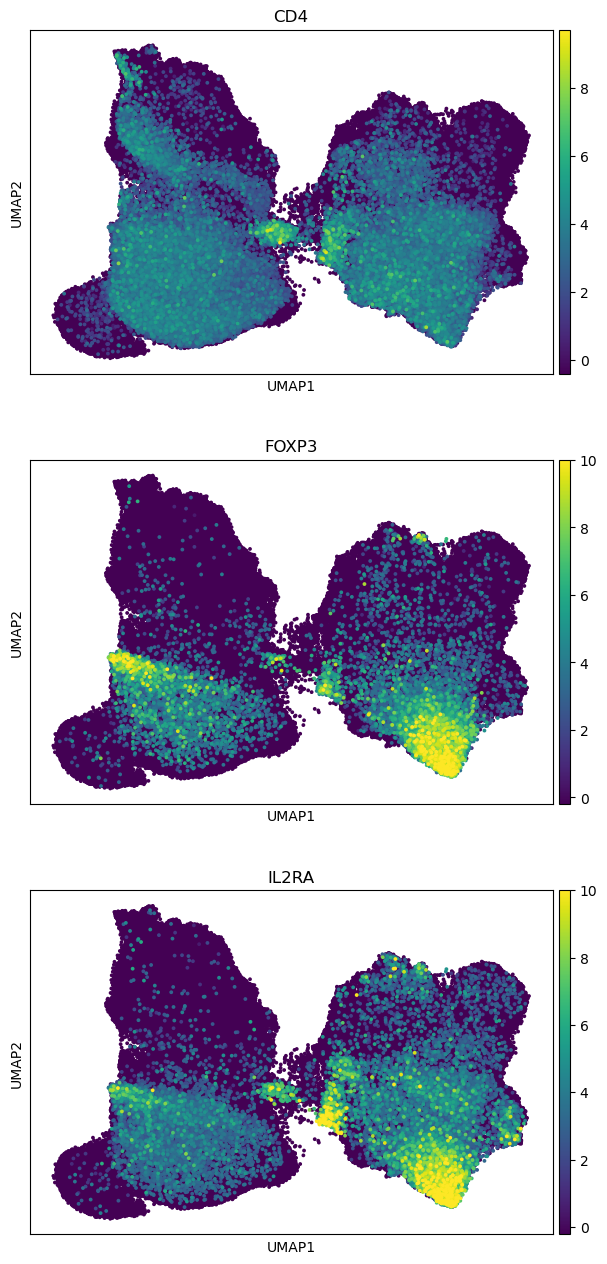

In [18]:
%matplotlib inline

marker_genes_CD4 = markers["CD4"]
marker_genes_CD8 = markers["CD8"]
# now plot cluster / annotation + all marker genes in one go
sc.pl.umap(
    adata_all,
    color=marker_genes_CD4,
    ncols=1,                # how many panels per row
    size=30,                # dot size
    legend_loc="right margin",
    cmap="viridis",         # continuous color map for gene expr.
)

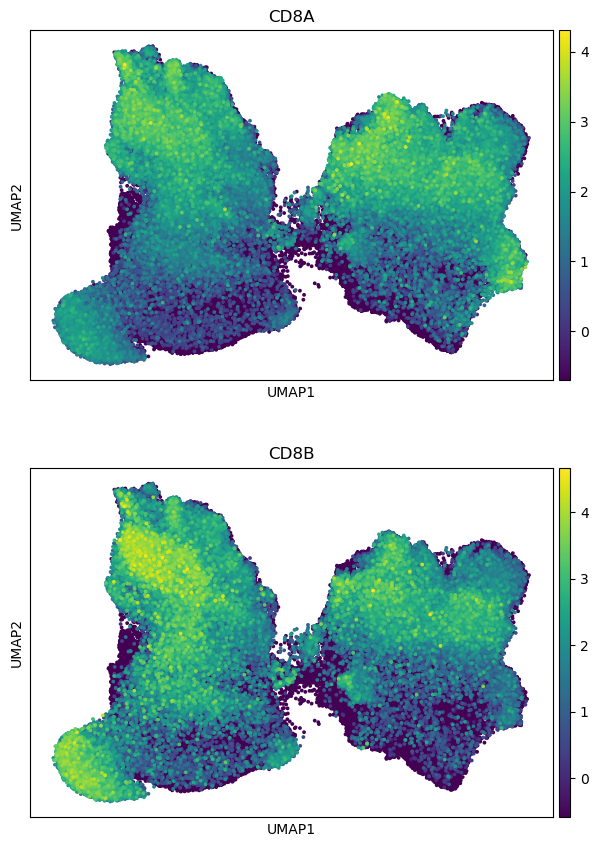

In [19]:
sc.pl.umap(
    adata_all,
    color=marker_genes_CD8,
    ncols=1,                # how many panels per row
    size=30,                # dot size
    legend_loc="right margin",
    cmap="viridis",         # continuous color map for gene expr.
)

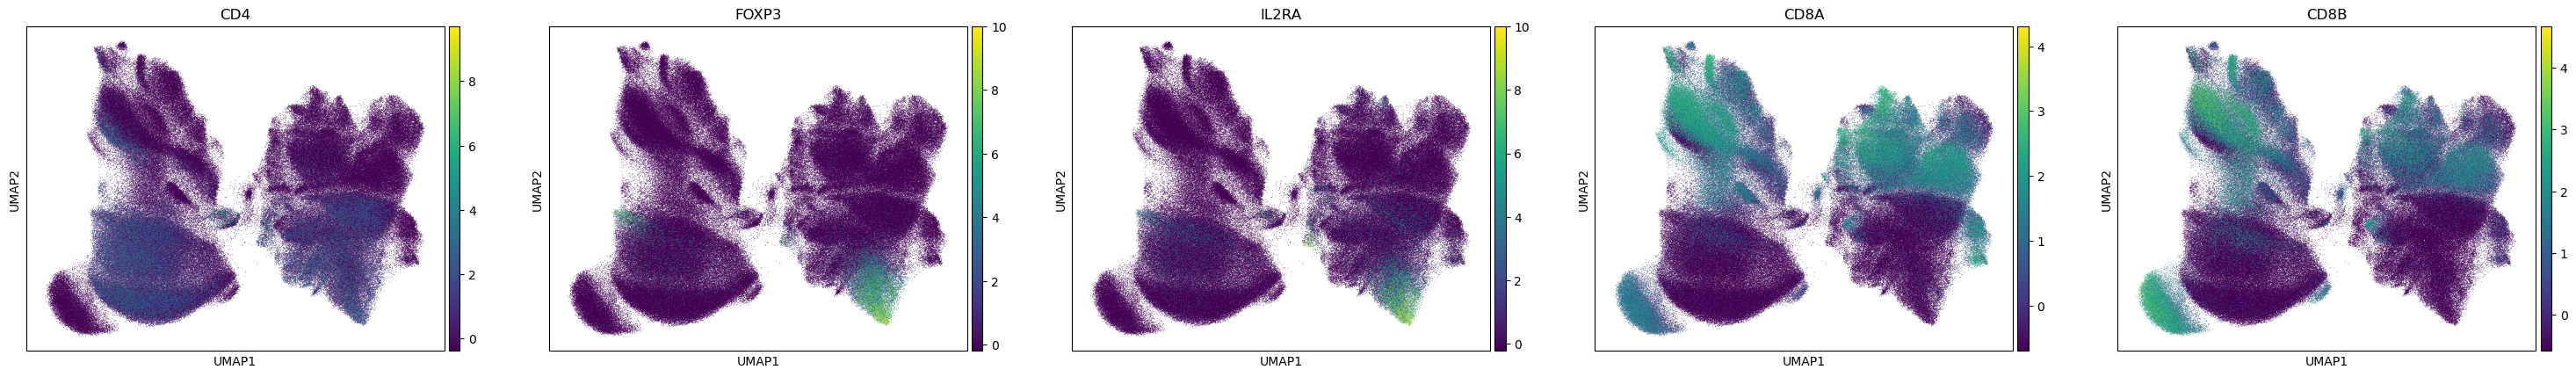

In [20]:
genes4 = marker_genes_CD4
genes8 = marker_genes_CD8

allgenes = genes4 + genes8

sc.pl.umap(
    adata_all,
    color=allgenes,
    ncols=5,
    size=1,                    # same dot size
    cmap="viridis",
    legend_loc="right margin"
)

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


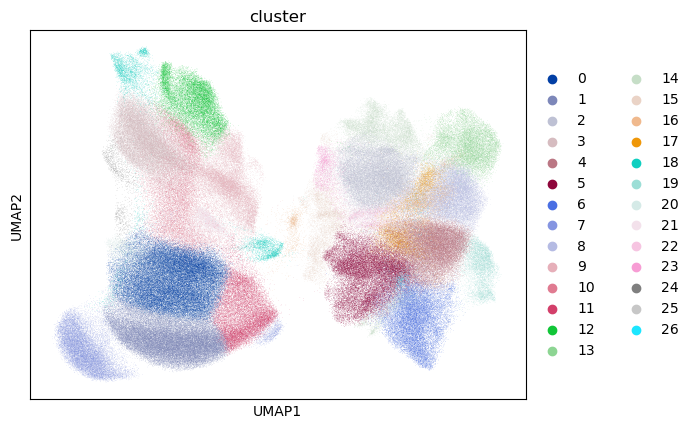

In [21]:
%matplotlib inline
sc.pl.umap(adata_all, color=["cluster"])

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


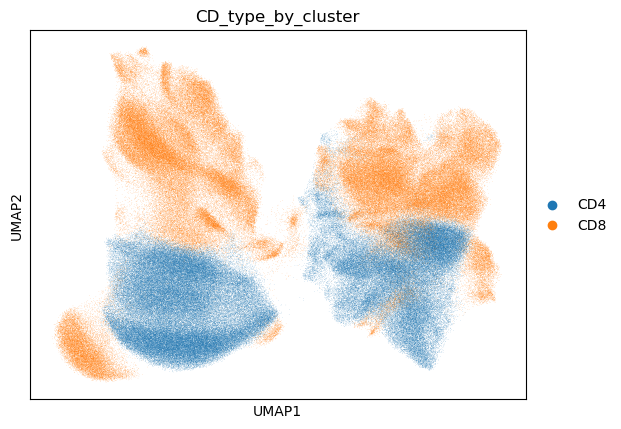

In [22]:
%matplotlib inline
sc.pl.umap(adata_all, color=["CD_type_by_cluster"])

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


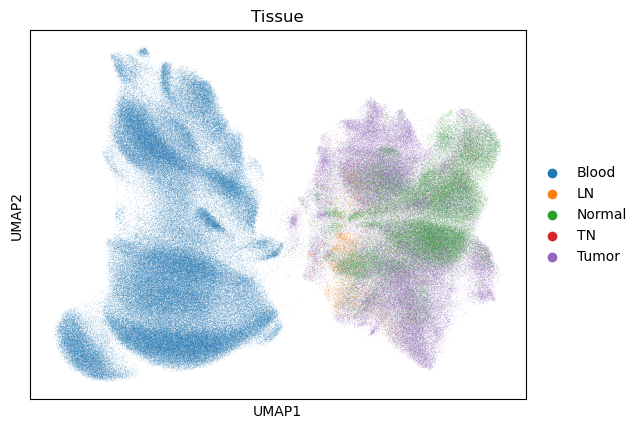

In [23]:
%matplotlib inline
sc.pl.umap(adata_all, color=["Tissue"])

In [24]:
import pandas as pd

# pull out your obs DataFrame
obs = adata_all.obs.copy()

# define how each subtype maps to the coarse CD4/CD8 call
subtype2coarse = { st: st.split('_')[1] for st in t_cell_types}

# create a new column with the mapped coarse type
obs['CD_type_from_predicted_l2'] = obs["SubCellType"].map(subtype2coarse)

# now find all cells where that mapped type !=  cluster‐based call
mismatches = obs[
    obs['CD_type_from_predicted_l2'] != obs['CD_type_by_cluster']
]

mismatches

n_genes_by_counts  log1p_n_genes_by_counts  \
CRC01-N-I_AAATGCCAGTTACGGG                1529                 7.333023   
CRC01-N-I_AAATGCCCACGCGAAA                2159                 7.677864   
CRC01-N-I_AAATGCCGTTACGACT                2142                 7.669962   
CRC01-N-I_AACTGGTCAGACAAAT                1915                 7.557995   
CRC01-N-I_AACTGGTGTTAAGTAG                1156                 7.053586   
...                                        ...                      ...   
CRC23-T-IV_TTTCCTCAGTGATCGG               1363                 7.218177   
CRC23-T-IV_TTTGCGCGTCTTCAAG               1473                 7.295735   
CRC23-T-IV_TTTGGTTGTAGCCTAT               1635                 7.400010   
CRC23-T-IV_TTTGGTTGTTGGGACA               1387                 7.235619   
CRC23-T-IV_TTTGTCAAGACTAGAT               1329                 7.192934   

                             total_counts  log1p_total_counts  \
CRC01-N-I_AAATGCCAGTTACGGG           2357            7.765569   
CRC01-N-I_AAATGCCCACGCGAAA           4232            8.350666   
CRC01-N-I_AAATGCCGTTACGACT           4527            8.418036   
CRC01-N-I_AACTGGTCAGACAAAT           3467            8.151333   
CRC01-N-I_AACTGGTGTTAAGTAG           1822            7.508239   
...                                   ...                 ...   
CRC23-T-IV_TTTCCTCAGTGATCGG          4144            8.329658   
CRC23-T-IV_TTTGCGCGTCTTCAAG          5286            8.573006   
CRC23-T-IV_TTTGGTTGTAGCCTAT          6021            8.703175   
CRC23-T-IV_TTTGGTTGTTGGGACA          3028            8.015988   
CRC23-T-IV_TTTGTCAAGACTAGAT          4135            8.327484   

                             pct_counts_in_top_50_genes  \
CRC01-N-I_AAATGCCAGTTACGGG                    18.625371   
CRC01-N-I_AAATGCCCACGCGAAA                    20.982987   
CRC01-N-I_AAATGCCGTTACGACT                    24.409101   
CRC01-N-I_AACTGGTCAGACAAAT                    18.921258   
CRC01-N-I_AACTGGTGTTAAGTAG                    23.710209   
...                                                 ...   
CRC23-T-IV_TTTCCTCAGTGATCGG                   39.816602   
CRC23-T-IV_TTTGCGCGTCTTCAAG                   43.113886   
CRC23-T-IV_TTTGGTTGTAGCCTAT                   43.398107   
CRC23-T-IV_TTTGGTTGTTGGGACA                   27.840159   
CRC23-T-IV_TTTGTCAAGACTAGAT                   39.564692   

                             pct_counts_in_top_100_genes  \
CRC01-N-I_AAATGCCAGTTACGGG                     25.965210   
CRC01-N-I_AAATGCCCACGCGAAA                     28.308129   
CRC01-N-I_AAATGCCGTTACGACT                     33.200795   
CRC01-N-I_AACTGGTCAGACAAAT                     26.564753   
CRC01-N-I_AACTGGTGTTAAGTAG                     32.601537   
...                                                  ...   
CRC23-T-IV_TTTCCTCAGTGATCGG                    54.512548   
CRC23-T-IV_TTTGCGCGTCTTCAAG                    59.137344   
CRC23-T-IV_TTTGGTTGTAGCCTAT                    59.059957   
CRC23-T-IV_TTTGGTTGTTGGGACA                    39.398943   
CRC23-T-IV_TTTGTCAAGACTAGAT                    55.187424   

                             pct_counts_in_top_200_genes  \
CRC01-N-I_AAATGCCAGTTACGGG                     36.105218   
CRC01-N-I_AAATGCCCACGCGAAA                     38.445180   
CRC01-N-I_AAATGCCGTTACGACT                     43.406229   
CRC01-N-I_AACTGGTCAGACAAAT                     36.804153   
CRC01-N-I_AACTGGTGTTAAGTAG                     43.798024   
...                                                  ...   
CRC23-T-IV_TTTCCTCAGTGATCGG                    65.371622   
CRC23-T-IV_TTTGCGCGTCTTCAAG                    69.409762   
CRC23-T-IV_TTTGGTTGTAGCCTAT                    69.058296   
CRC23-T-IV_TTTGGTTGTTGGGACA                    51.948481   
CRC23-T-IV_TTTGTCAAGACTAGAT                    66.166868   

                             pct_counts_in_top_500_genes     orig.ident  \
CRC01-N-I_AAATGCCAGTTACGGG                     56.342809  SeuratProject   
CRC01-N-I_AAATGCCCACGCGAAA                    

In [25]:
obs['mismatch'] = (
    obs['CD_type_from_predicted_l2'] != 
    obs['CD_type_by_cluster']
)

cluster_summary = (
    obs
    .groupby('cluster')['mismatch']
    .agg(
        n_total='count', 
        n_mismatch='sum', 
        prop_mismatch='mean'
    )
    .sort_values('prop_mismatch', ascending=False)
)

cluster_summary

n_total  n_mismatch  prop_mismatch
cluster                                    
17          7244        3834       0.529266
15          7958        4017       0.504775
18          6819        2846       0.417363
25          1094         427       0.390311
16          7334        2628       0.358331
22          3950        1305       0.330380
24          1608         488       0.303483
3          30319        6673       0.220093
14         12304        2269       0.184412
26           696          99       0.142241
21          4337         583       0.134425
10         18066        2170       0.120115
5          27147        2663       0.098096
23          3005         284       0.094509
0          46958        4030       0.085821
4          29601        2319       0.078342
9          18416        1379       0.074881
11         17933        1202       0.067027
2          31521        1912       0.060658
19          6662         234       0.035125
6          20496         564       0.027518
8          18529         445       0.024016
1          42533        1004       0.023605
20          5628          76       0.013504
7          18720         188       0.010043
13         12792          25       0.001954
12         15587           4       0.000257

Clusters to highlight: ['17', '15', '18', '25', '16', '22', '24', '3']


/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


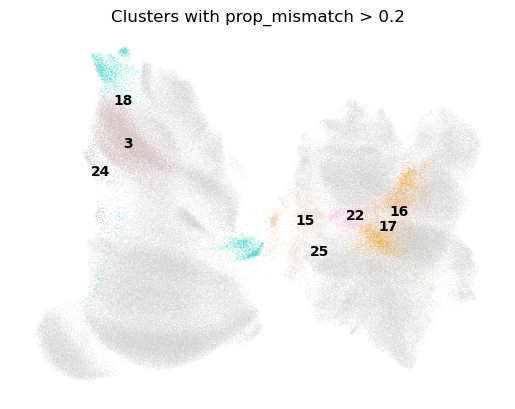

In [26]:
mismatch_clusters = (
    cluster_summary               # the table you printed in cell [17]
      .query("prop_mismatch > 0.2")
      .index                      # these are the cluster labels
      .astype(str)                # Scanpy stores cluster labels as strings
      .tolist()
)

print("Clusters to highlight:", mismatch_clusters)

# ---  draw the UMAP, colouring by cluster and highlighting just those ------
sc.pl.umap(
    adata_all,
    color="cluster",              # column that stores the cluster ID
    groups=mismatch_clusters,     # only show these clusters in colour
    legend_loc="on data",         # put the labels on the plot
    frameon=False,
    na_in_legend=False, 
    title="Clusters with prop_mismatch > 0.2"
)

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


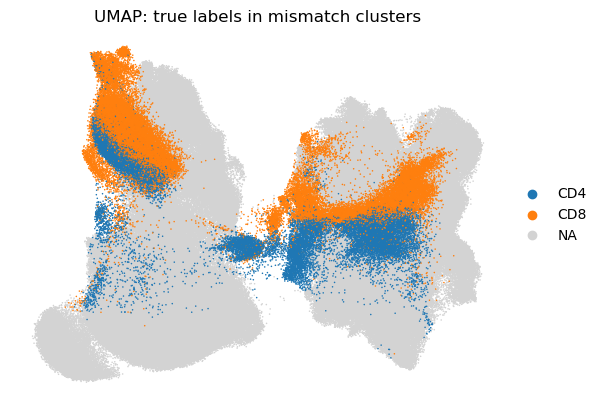

In [27]:
t_cells = {'CD4':[
'c01_CD4_Tn_CCR7',
 'c02_CD4_Tn_SELL',
 'c03_CD4_Tn_NR4A2',
 'c04_CD4_Tcm_ANXA1',
 'c05_CD4_Tcm_GPR183',
 'c06_CD4_Trm_HSPA1A',
 'c07_CD4_Th17_CTSH',
 'c08_CD4_Tfh_CXCL13_IL6ST',
 'c09_CD4_Th1_CXCL13_HAVCR2',
 'c10_CD4_Temra_GZMB',
 'c11_CD4_Treg_FOXP3',
 'c12_CD4_Treg_KLRB1',
 'c13_CD4_Treg_TNFRSF9',
 'c14_CD4_MT'], 'CD8':[
 'c15_CD8_Tn_CCR7',
 'c16_CD8_Tn_SELL',
 'c17_CD8_Tcm_GPR183',
 'c18_CD8_Tcm_ANXA1',
 'c19_CD8_Tem_CMC1',
 'c20_CD8_Tem_GZMK',
 'c21_CD8_Trm_XCL1',
 'c22_CD8_Trm_HSPA1B',
 'c23_CD8_Tex_LAYN',
 'c24_CD8_Temra_CX3CR1',
 'c25_CD8_Temra_TYROBP',
 'c26_CD8_MAIT_KLRB1',
 'c27_CD8_MAIT_SLC4A10',
 'c28_CD8_IEL_CD160']
}
sub2label = {}
for label, subs in t_cells.items():
    for sub in subs:
        sub2label[sub] = label

#  map existing SubCellType column to the new labels
adata_all.obs['cell_type_true_label'] = (
    adata_all.obs['SubCellType']
    .map(sub2label)
    .fillna('Unknown')      # in case there are SubCellTypes not in t_cells
)

# boolean mask of cells in those clusters
mask = adata_all.obs['cluster'].astype(str).isin(mismatch_clusters)

# create a one‐column “highlight”:
#   CD4 or CD8 for mismatches, Other otherwise
adata_all.obs['highlight'] = np.where(
    mask,
    adata_all.obs['cell_type_true_label'],
    'Other'
)

# now plot exactly like your first plot:
sc.pl.umap(
    adata_all,
    color='highlight',          # this column is now categorical: CD4, CD8, Other
    groups=['CD4','CD8'],       # only these get the Scanpy default colors
    size=5,                    # same dot size as before
    frameon=False,
    legend_loc='right margin',  # or 'on data' if you prefer labels placed over clusters
    title='UMAP: true labels in mismatch clusters'
)

In [28]:
adata_all.obs.to_csv('cell_types.csv',index = True)